<a href="https://colab.research.google.com/github/MadhavAggarwal86/Action-Recognition--Football-Basketball-Volleyball/blob/main/Action_Recognition_Football_Volleyball_Basketball.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
# Installing libraries.
!pip install pafy youtube-dl moviepy
# Importing libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [43]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [44]:
%%capture

# Downlaod the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

#Extracting it
!unrar x UCF50.rar

['BaseballPitch', 'Basketball', 'BenchPress', 'Biking', 'Billiards', 'BreastStroke', 'CleanAndJerk', 'Diving', 'Drumming', 'Fencing', 'GolfSwing', 'HighJump', 'HorseRace', 'HorseRiding', 'HulaHoop', 'JavelinThrow', 'JugglingBalls', 'JumpRope', 'JumpingJack', 'Kayaking', 'Lunges', 'MilitaryParade', 'Mixing', 'Nunchucks', 'PizzaTossing', 'PlayingGuitar', 'PlayingPiano', 'PlayingTabla', 'PlayingViolin', 'PoleVault', 'PommelHorse', 'PullUps', 'Punch', 'PushUps', 'RockClimbingIndoor', 'RopeClimbing', 'Rowing', 'SalsaSpin', 'SkateBoarding', 'Skiing', 'Skijet', 'SoccerJuggling', 'Swing', 'TaiChi', 'TennisSwing', 'ThrowDiscus', 'TrampolineJumping', 'VolleyballSpiking', 'WalkingWithDog', 'YoYo']


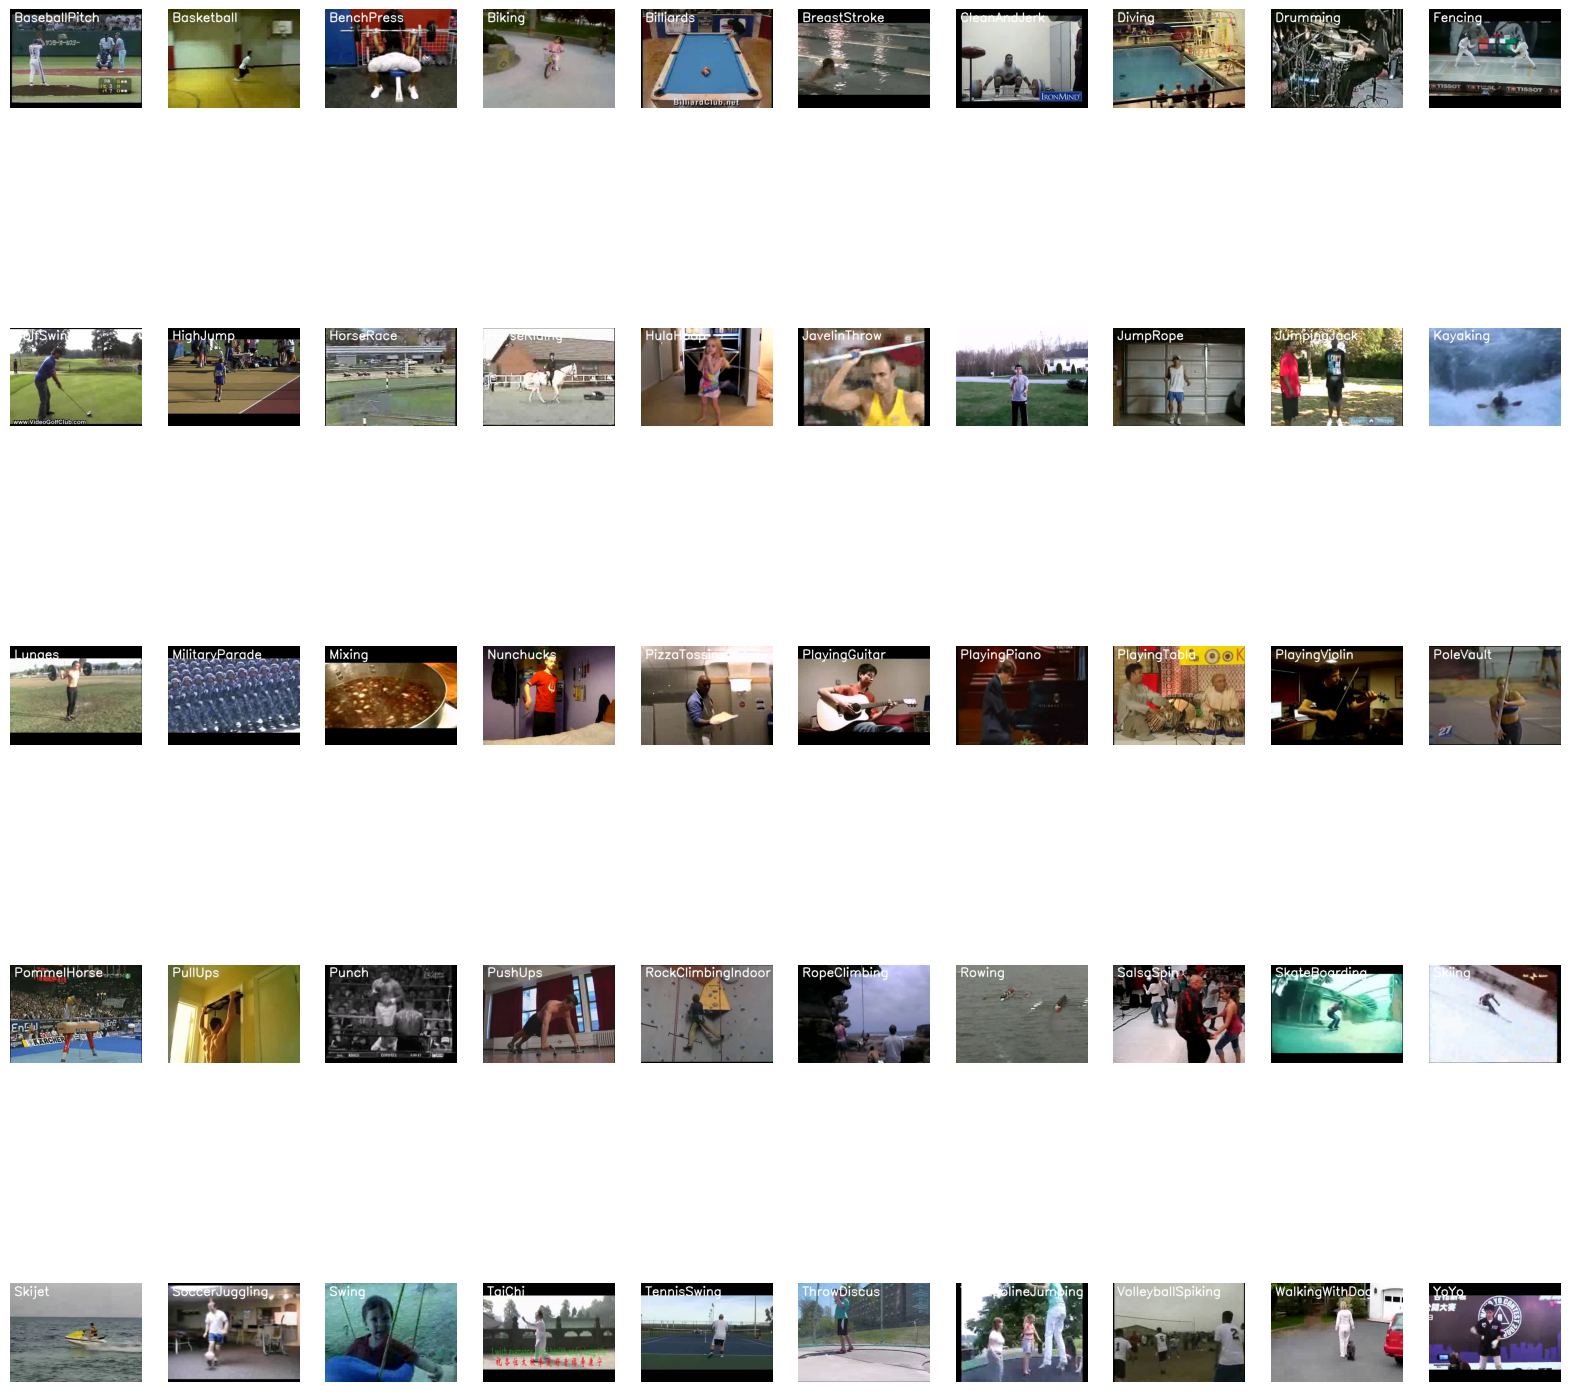

In [45]:


plt.figure(figsize=(20, 20))

# Get all the class names
all_classes_names = sorted(os.listdir('UCF50'))  # Sorting ensures consistent order
print(all_classes_names)

# Iterate through all 50 class names
for counter, class_name in enumerate(all_classes_names, 1):
    video_files_names_list = os.listdir(f'UCF50/{class_name}')

    if not video_files_names_list:  # Check if the directory is empty
        continue

    selected_video_file_name = random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'UCF50/{class_name}/{selected_video_file_name}')

    ret, bgr_frame = video_reader.read()
    video_reader.release()

    if not ret:  # Handle read failure
        continue

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                1, (255, 255, 255), 2)

    plt.subplot(5, 10, counter)  # 5 rows, 10 columns for all 50 classes
    plt.imshow(rgb_frame)
    plt.axis('off')

plt.show()


In [46]:
# resizing the image, frame_length
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20

DATASET_DIR = "UCF50"
CLASSES_LIST = ["Basketball", "VolleyballSpiking", "SoccerJuggling"]

In [47]:
def frames_extraction(video_path):

    frames_list = []
    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    video_reader.release()

    return frames_list

In [48]:
def create_dataset():

    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):

        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:

                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [49]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Basketball
Extracting Data of Class: VolleyballSpiking
Extracting Data of Class: SoccerJuggling


In [50]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [51]:
# Spliting the Dataset
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

In [64]:
def create_convlstm_model():


    # used a Sequential model
    model = Sequential()

    # Model Architecture.


    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    # model summary.
    model.summary()

    return model

In [65]:
# convlstm model.
convlstm_model = create_convlstm_model()
print("Model Created Successfully!")

  super().__init__(**kwargs)



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d_8 (ConvLSTM2D)           │ (None, 20, 62, 62, 4)       │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_8 (MaxPooling3D)       │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_9 (ConvLSTM2D)           │ (None, 20, 29, 29, 8)       │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_9 (MaxPooling3D)       │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_10 (ConvLSTM2D)          │ (None, 20, 13, 13, 14)      │          11,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_10 (MaxPooling3D)      │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_11 (ConvLSTM2D)          │ (None, 20, 5, 5, 16)        │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_11 (MaxPooling3D)      │ (None, 20, 3, 3, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2880)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │           8,643 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,643 (162.67 KB)

 Trainable params: 41,643 (162.67 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


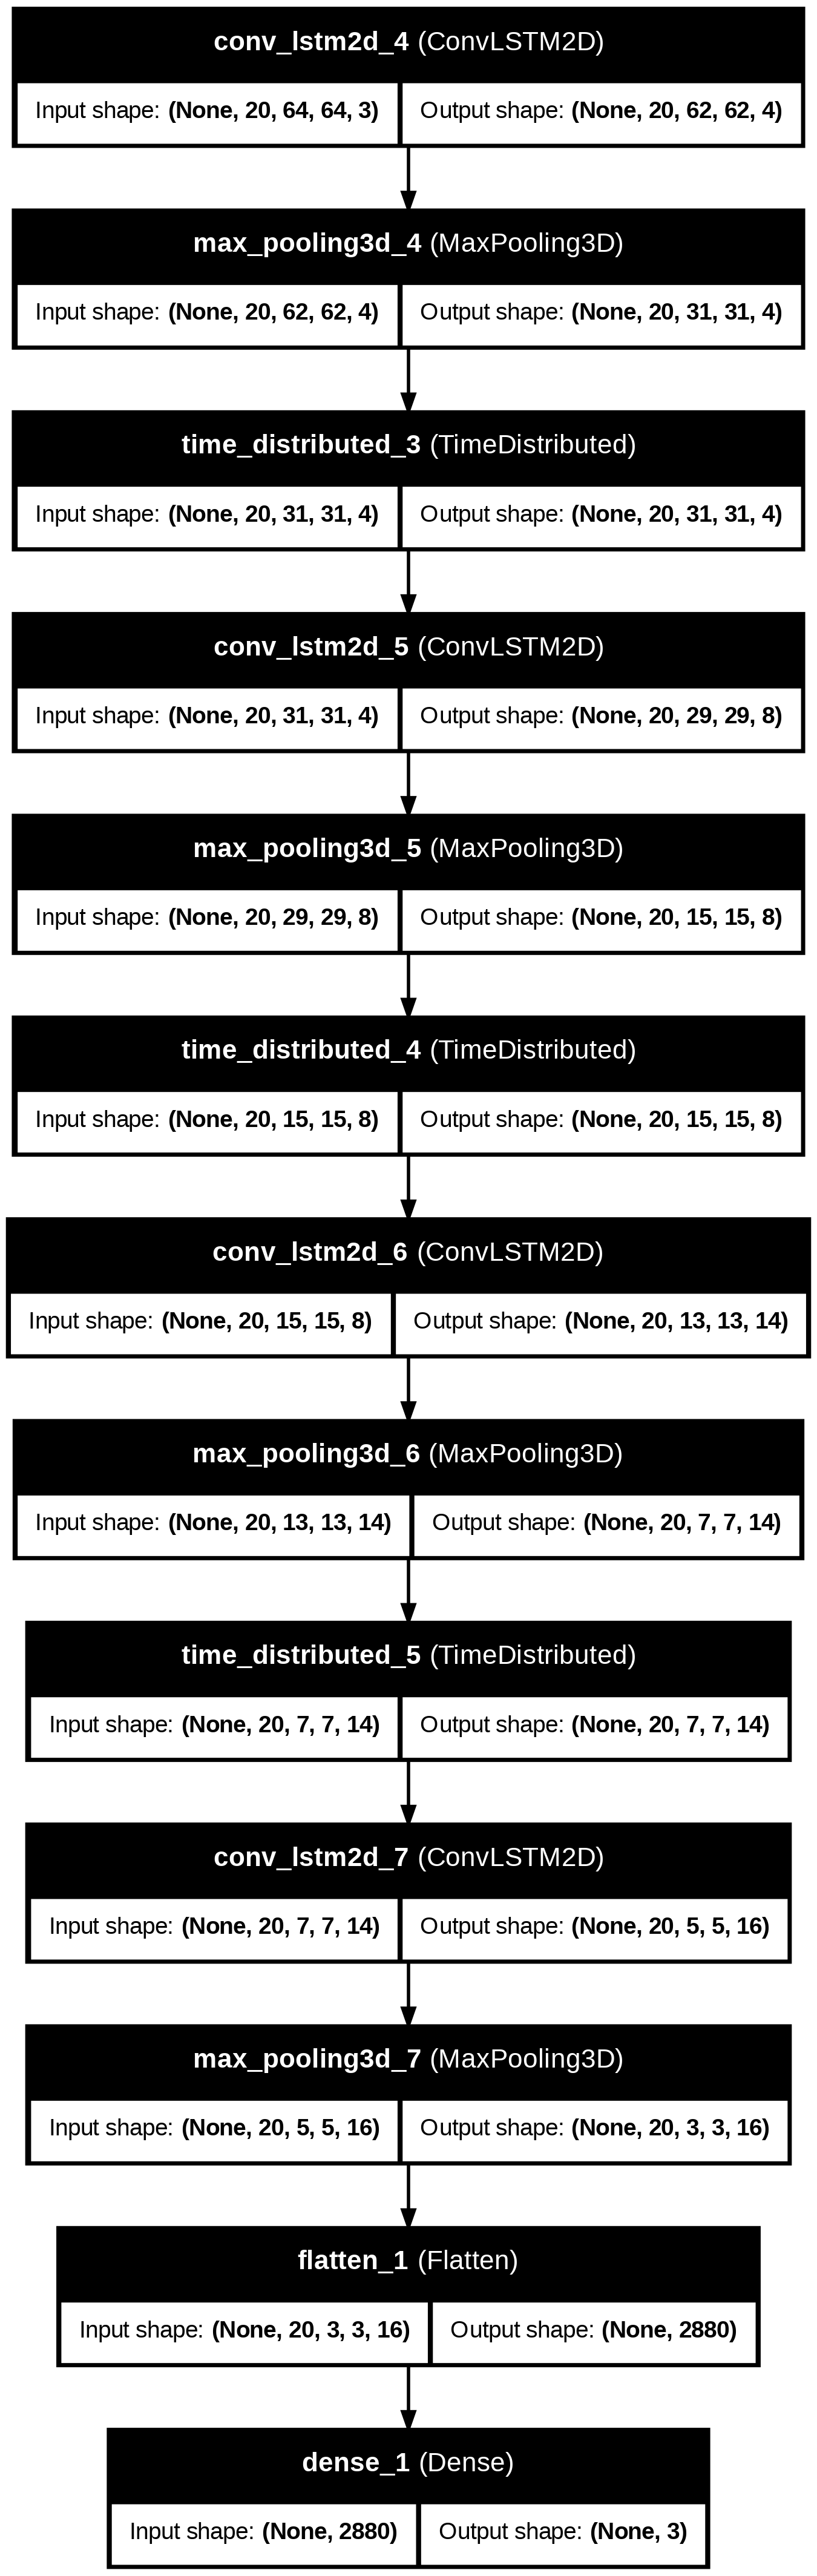

In [54]:
# Plotting the structure
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [55]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Training the model
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 62s 137ms/step - accuracy: 0.3771 - loss: 1.1103 - val_accuracy: 0.3065 - val_loss: 1.1011
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.3738 - loss: 1.0965 - val_accuracy: 0.3710 - val_loss: 1.0858
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.4261 - loss: 1.0796 - val_accuracy: 0.4516 - val_loss: 1.0589
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.4520 - loss: 1.0363 - val_accuracy: 0.4516 - val_loss: 0.9891
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.4946 - loss: 1.0089 - val_accuracy: 0.4839 - val_loss: 0.9557
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5706 - loss: 0.8824 - val_accuracy: 0.5645 - val_loss: 0.9555
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.7216 - loss: 0.7692 - val_accuracy: 0.6935 - val_loss: 0.8494
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.7114 - loss: 0.6321 - val_accuracy: 0.6935 

In [56]:
# Evaluating model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 543ms/step - accuracy: 0.8720 - loss: 0.6780


In [66]:
# loss and accuracy
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'convlstm_model_Date_Time_{current_date_time_string}_Loss_{model_evaluation_loss}.h5'

# Saving the Model.
convlstm_model.save(model_file_name)

In [67]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

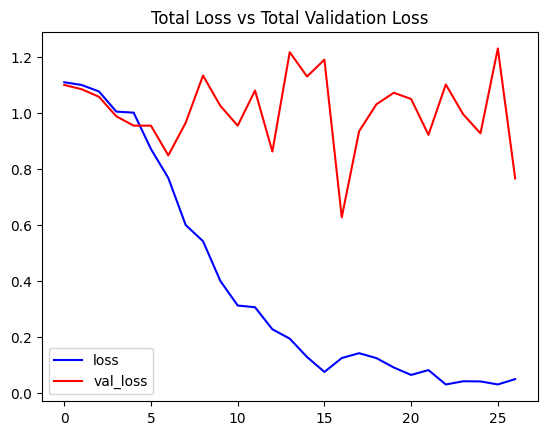

In [68]:
# Visualizing the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

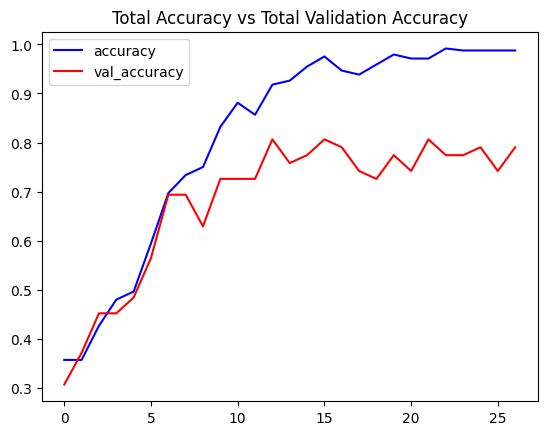

In [69]:
# Visualizing the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [70]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):

    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    predicted_class_name = ''

    while video_reader.isOpened():

        ok, frame = video_reader.read()

        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255

        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:

            predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_queue, axis = 0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]

        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

In [71]:
# Output directory
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

In [72]:
# Construct the output video path.
video_title = "5_penalty2"  # Replace with the actual video title
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video('/content/5_penalty2.mp4', output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━

Moviepy - Done !
Moviepy - video ready __temp__.mp4
